# Projet : Prédiction de l'Approbation de Prêts

## Description

Ce projet a pour objectif de développer un modèle de prédiction pour l'approbation de prêts en utilisant la base de données `loan_sanction_train`. Cette base contient des informations sur les demandeurs de prêts, leurs revenus, antécédents de crédit, montant du prêt demandé, etc. Le but principal est de créer un modèle de machine learning capable de prédire si une demande de prêt sera approuvée, en se basant sur ces caractéristiques.

## Objectifs

- Analyse exploratoire des données pour comprendre les tendances et les corrélations.
- Prétraitement des données pour gérer les valeurs manquantes et les caractéristiques catégorielles.
- Entraînement de modèles tels que les arbres de décision, les forêts aléatoires et la régression logistique.
- Évaluation des modèles avec précision, recall, AUC-ROC pour sélectionner le meilleur.
- Optimisation des hyperparamètres pour améliorer les performances du modèle choisi.

In [248]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

## PREPARATION ET ANALYSE DES DONNEES

### Description du Dataset :

| Variable | Description |
|----------|-------------|
| Loan_ID | Identifiant unique du prêt |
| Gender | Genre (Homme/ Femme) |
| Married | Statut matrimonial (Marié : Oui/Non) |
| Dependents | Nombre de personnes à charge |
| Education | Niveau d'éducation (Diplômé/ Non diplômé) |
| Self_Employed | Travailleur indépendant (Oui/Non) |
| ApplicantIncome | Revenu de l'applicant |
| CoapplicantIncome | Revenu du co-applicant |
| LoanAmount | Montant du prêt en milliers |
| Loan_Amount_Term | Durée du prêt en mois |
| Credit_History | Historique de crédit conforme aux directives (Oui/Non) |
| Property_Area | Zone de propriété (Urbain/ Semi-urbain/ Rural) |
| Loan_Status | Statut du prêt (Approuvé : Oui/Non) |


In [249]:
loan_data = pd.read_csv("loan_sanction_train.csv")

In [250]:
#creér une copie pour commencer a manipuler les données
data = loan_data.copy()

In [251]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [252]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [253]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [254]:
# Affichage du nombre de valeurs manquantes pour chaque variable
print(data.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


**Revenu des demandeurs et co-demandeurs :**
- Le revenu des demandeurs varie considérablement, allant de 150 à 81 000. On remarque une divergence marquée entre le revenu moyen et médian, indiquant une asymétrie dans la distribution.
- Le revenu des co-demandeurs présente également une variabilité, de 0 à 41 667, avec une moyenne et une médiane plus proches, suggérant une distribution moins asymétrique.

**Montant du prêt :**
- Les montants des prêts demandés varient de 9 à 700 milliers. La majorité des prêts semblent se situer dans une fourchette inférieure, avec une moyenne de 146 milliers.

**Durée du prêt :**
- La durée des prêts varie de 12 à 480 mois, avec une moyenne de 342 mois (soit 28,5 ans). La plupart des prêts semblent avoir une durée standard de remboursement de 360 mois (30 ans).

**Historique de crédit :**
- Environ 84% des demandeurs ont un historique de crédit conforme aux directives. Cela peut être un facteur clé pour l'approbation des prêts.

**Valeurs manquantes :**
- Il existe des valeurs manquantes Credit_History, Loan_Amount_Term, LoanAmount, Self_Employed, Dependents,Gender, Married

In [255]:
cat_var = ['Gender','Married','Dependents','Education','Self_Employed', 'Property_Area', 'Loan_Status']
num_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

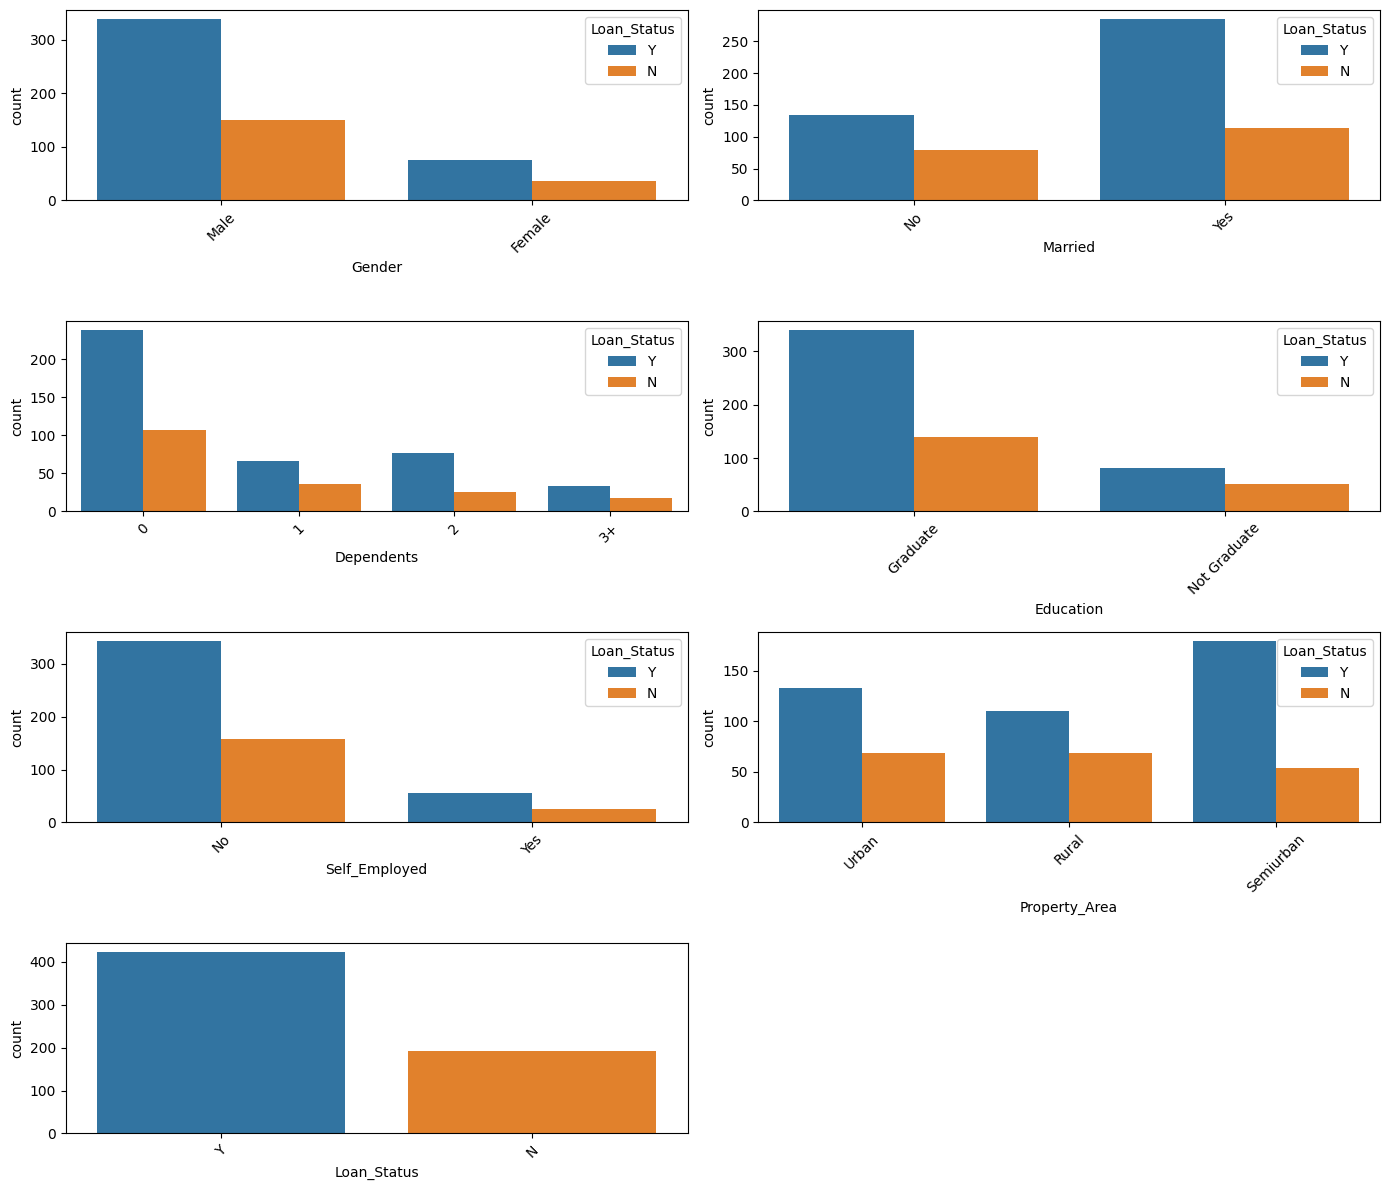

In [256]:
#barplot for categorical variables
plt.figure(figsize=(14,12))
for i,col in enumerate(cat_var,1):
    plt.subplot(4,2,i)
    sns.countplot(x=col,hue='Loan_Status', data=data)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

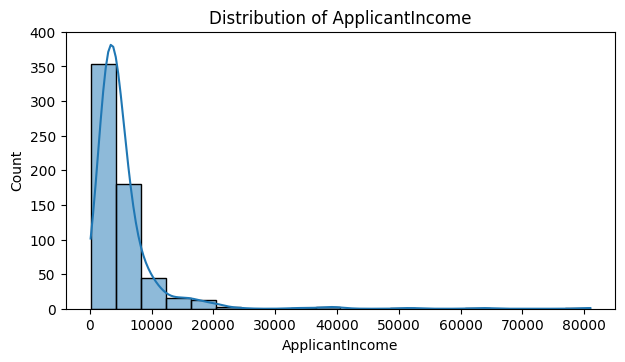

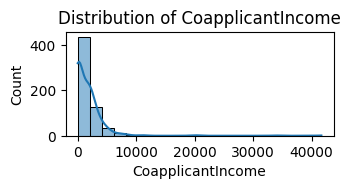

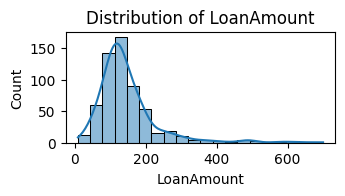

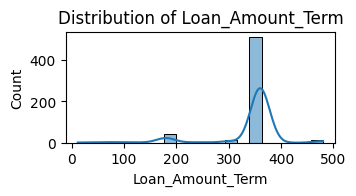

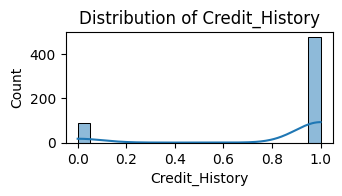

In [257]:
# visualize the distribution of numerical feature
plt.figure(figsize=(12,10))
for i, col in enumerate(num_var, 1):
    plt.subplot(3,2,i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

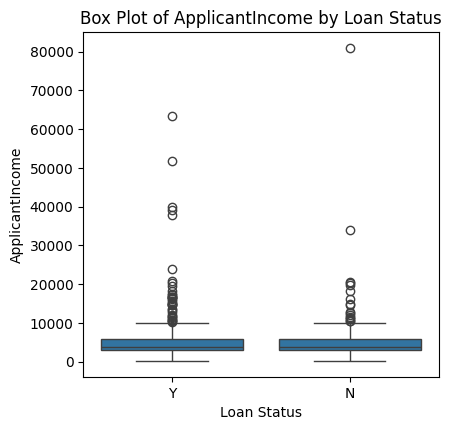

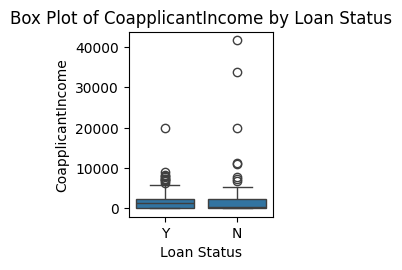

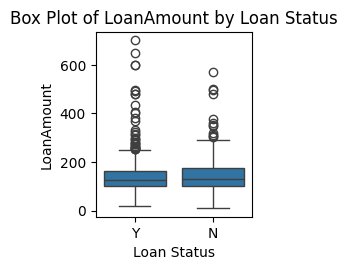

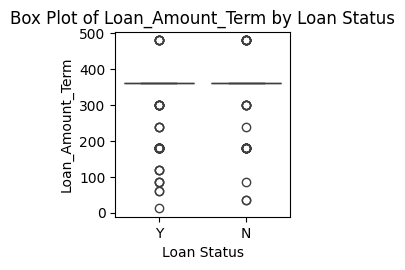

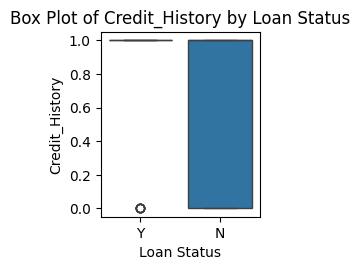

In [258]:
# Box plots to detect outliers in numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_var, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Loan_Status', y=col, data=data)
    plt.title(f'Box Plot of {col} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

- Il y a moins de demandes de prêt émanant des travailleurs indépendants, suggérant qu'ils pourraient avoir un revenu suffisant pour subvenir à leurs besoins.
- Une part significative des personnes mariées demande des prêts.
- Un schéma clair émerge : avoir un historique de crédit réduit considérablement le risque de rejet de la demande de prêt.
- Environ 50% des demandes de prêt des femmes ont été rejetées, alors que plus de 50% des demandes des hommes ont été approuv
- Il y a quelques valeurs aberrantes et des données manquantes.
- Plus de 75 % des demandeurs sont des hommes et plus de 70 % sont mariés.
- Plus de la moitié des demandeurs n'ont aucun personne à charge.
- Enfin, environ 68 % des demandes sont approuvées par la banque, ce qui est décent.
- On peut remarquer dans nos donnés que le profil des client est plutot des personnes graduate, not self employed, masculin, mariée, avec zéro dependant.

In [259]:
#traitement des valeurs manquantes
"""
Remplacer par le mode pour les variables categorielle et la moyenne pour les variables numérique
"""

mode_gender = data['Gender'].mode()[0]
data['Gender'].fillna(mode_gender, inplace = True)

#filling the missing values in married column
mode_married = data['Married'].mode()[0]
data['Married'].fillna(mode_married, inplace = True)

#filling the missing values in dependents column
mode_Dependents = data['Dependents'].mode()[0]
data['Dependents'].fillna(mode_Dependents, inplace = True)

#Education column has no missing values

#filling the missing values in Self_Employed column
mode_self = data['Self_Employed'].mode()[0]
data['Self_Employed'].fillna(mode_self, inplace = True)

#filling the missing values in Property_Area column
mode_self = data['Property_Area'].mode()[0]
data['Property_Area'].fillna(mode_self, inplace = True)

#filling the missing values in Credit_History column
mode_credit = data['Credit_History'].mode()[0]
data['Credit_History'].fillna(mode_credit, inplace = True)

#filling missing values in numerical columns left
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace = True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace = True)
print("")
print("")
print("")
print("Missing Values in Filled Data")
print("")
miss_vals = data.isnull()
print(miss_vals.sum())




Missing Values in Filled Data

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [260]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [261]:
#coder les variables catégorielle - utilisation du one-hot encoding

# Créer un objet OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')  # Drop 'first' to avoid multicollinearity

# Appliquer le one-hot encoding sur les colonnes catégorielles
transformed_data = ohe.fit_transform(data[cat_var])

# Obtenir les noms des colonnes après l'encodage
encoded_column_names = ohe.get_feature_names_out(cat_var)

# Créer un nouveau DataFrame avec les noms de colonnes appropriés
transformed_df = pd.DataFrame(transformed_data, columns=encoded_column_names)

# Concaténer le DataFrame encodé avec les colonnes restantes du DataFrame d'origine
data = pd.concat([transformed_df, data.drop(columns=cat_var)], axis=1)

print("DataFrame avec one-hot encoding : ")
data


DataFrame avec one-hot encoding : 


/home/vmuser/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,LP001002,5849,0.0,146.412162,360.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LP001003,4583,1508.0,128.000000,360.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,LP001005,3000,0.0,66.000000,360.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,LP001006,2583,2358.0,120.000000,360.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,LP001008,6000,0.0,141.000000,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,LP002978,2900,0.0,71.000000,360.0,1.0
610,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LP002979,4106,0.0,40.000000,180.0,1.0
611,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,LP002983,8072,240.0,253.000000,360.0,1.0
612,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,LP002984,7583,0.0,187.000000,360.0,1.0


In [262]:
# Suppression de la colonne spécifiée
data = data.drop("Loan_ID", axis=1)

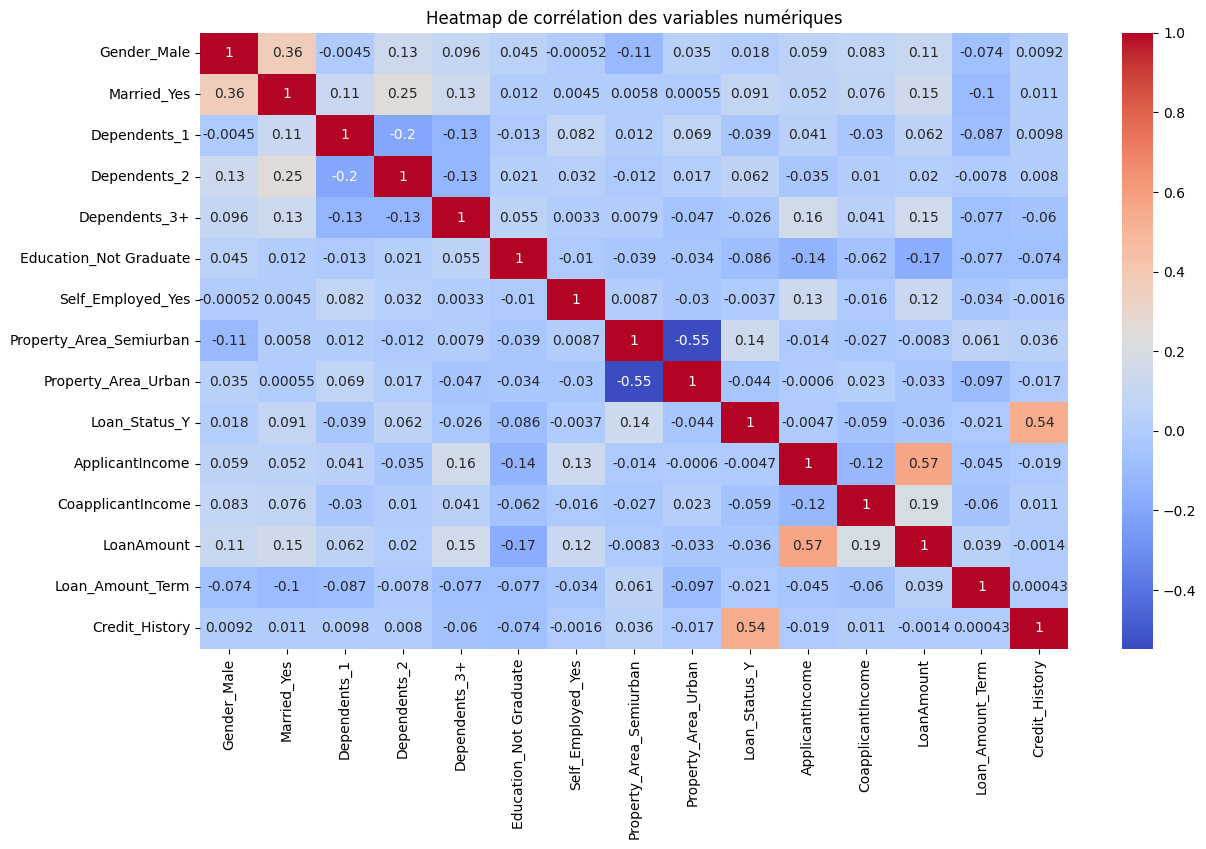

In [263]:
# Sélection des variables numériques
num_var = data.columns.tolist()  
df_num = data[num_var]

# Génération de la heatmap de corrélation
plt.figure(figsize=(14, 8))
sns.heatmap(df_num.corr(), cmap='coolwarm', annot=True)
plt.title('Heatmap de corrélation des variables numériques')
plt.show()

- Credit_History semble être le facteur le plus significatif pour l'approbation des prêts, suivi par Property_Area_Semiurban et le statut matrimonial (Married_Yes).

In [264]:
x=data.drop(['Loan_Status_Y'],axis=1)
y=data['Loan_Status_Y']

In [265]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [266]:
print(x_test.shape,
y_test.shape,
x_train.shape,
y_train.shape)

(123, 14) (123,) (491, 14) (491,)


In [267]:
#Normalisation des variables en appliquant le standarScaler (une série finale centrée et réduite)
std=StandardScaler()
x_train=std.fit_transform(x_train)
def scaling(x):
    return std.transform(x)

In [268]:
x_test=scaling(x_test)

## MODELISATION ET EVALUATION

Pour la phase de modélisation, nous avons choisi d'utiliser trois techniques distinctes afin de prédire le statut des prêts : la régression logistique, les arbres de décision et les forêts aléatoires. Chaque algorithme présente ses propres avantages : la régression logistique est simple et rapide, les arbres de décision offrent une interprétabilité accrue, tandis que les forêts aléatoires sont adaptées aux ensembles de données complexes et offrent souvent de très bonnes performances prédictives.

Notre objectif est de comparer et d'évaluer ces modèles pour déterminer celui qui convient le mieux à notre ensemble de données et qui peut prédire de manière optimale le statut des prêts. Cette démarche nous permettra de sélectionner l'algorithme le plus adéquat pour notre cas spécifique, en garantissant des prédictions précises et utiles pour la prise de décision concernant l'approbation des prêts.

### Régression logistique

In [269]:
#Application de la régression logistique

# Initialisation du modèle de régression logistique
model_log = LogisticRegression()
model_log.fit(x_train, y_train)

LogisticRegression()

In [270]:
preds_ytrain_log=model_log.predict(x_train)
preds_ytest_log=model_log.predict(x_test)

In [271]:
# Évaluation du modèle
accuracy_train = accuracy_score(y_train, preds_ytrain_log)
accuracy_test = accuracy_score(y_test, preds_ytest_log)
print(f"Précision du modèle sur les données d'entraînement : {round(accuracy_train*100, 2)}%")
print(classification_report(y_train, preds_ytrain_log))
print(f"Précision du modèle sur les données de test : {round(accuracy_test*100, 2)}%")
print(classification_report(y_test, preds_ytest_log))

Précision du modèle sur les données d'entraînement : 81.87%
              precision    recall  f1-score   support

         0.0       0.92      0.44      0.60       149
         1.0       0.80      0.98      0.88       342

    accuracy                           0.82       491
   macro avg       0.86      0.71      0.74       491
weighted avg       0.84      0.82      0.80       491

Précision du modèle sur les données de test : 78.86%
              precision    recall  f1-score   support

         0.0       0.95      0.42      0.58        43
         1.0       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



En observant les mesures de précision, recall et F1-score pour chaque classe, on voit que la classe 0.0 (la classe minoritaire) présente une recall assez basse mais une précision plus élevée sur les deux ensembles. La moyenne pondérée des mesures (précision, recall, F1-score) est plus faible pour la classe minoritaire, ce qui confirme que le modèle a plus de difficultés à bien la prédire.  

Il semble y avoir un bon équilibre entre la précision et le rappel pour la classe majoritaire (1.0), mais des performances relativement faibles pour la classe minoritaire (0.0). Il pourrait être intéressant d'explorer des techniques spécifiques pour améliorer la prédiction de la classe minoritaire, comme l'utilisation de méthodes de rééchantillonnage comme SMOTE 

In [272]:
smote=SMOTE()
x,y=smote.fit_resample(x,y)

In [273]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [274]:
print(x_test.shape,
y_test.shape,
x_train.shape,
y_train.shape)

(169, 14) (169,) (675, 14) (675,)


In [275]:
#Normalisation des variables en appliquant le standarScaler (une série finale centrée et réduite)
std=StandardScaler()
x_train=std.fit_transform(x_train)

In [276]:
x_test=scaling(x_test)

In [277]:
#Application de la régression logistique

# Initialisation du modèle de régression logistique
model_log_smote = LogisticRegression()
model_log_smote.fit(x_train, y_train)
preds_ytrain_log_smote=model_log_smote.predict(x_train)
preds_ytest_log_smote=model_log_smote.predict(x_test)

# Évaluation du modèle
accuracy_train = accuracy_score(y_train, preds_ytrain_log_smote)
accuracy_test = accuracy_score(y_test, preds_ytest_log_smote)
print(f"Précision du modèle sur les données d'entraînement : {round(accuracy_train*100, 2)}%")
print(classification_report(y_train, preds_ytrain_log_smote))
print(f"Précision du modèle sur les données de test : {round(accuracy_test*100, 2)}%")
print(classification_report(y_test, preds_ytest_log_smote))

Précision du modèle sur les données d'entraînement : 77.19%
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.72       328
         1.0       0.72      0.92      0.81       347

    accuracy                           0.77       675
   macro avg       0.80      0.77      0.76       675
weighted avg       0.80      0.77      0.77       675

Précision du modèle sur les données de test : 67.46%
              precision    recall  f1-score   support

         0.0       0.85      0.50      0.63        94
         1.0       0.59      0.89      0.71        75

    accuracy                           0.67       169
   macro avg       0.72      0.70      0.67       169
weighted avg       0.74      0.67      0.67       169



Il semble qu'après l'application de SMOTE, le modèle ait tendance à prédire moins précisément la classe minoritaire (0.0) mais à mieux détecter ses vrais positifs, ce qui a entraîné une diminution de la précision mais une amélioration du recall pour cette classe.

### Les arbres de décision

In [278]:
#Application du DecisionTree
model_dt=DecisionTreeClassifier(max_depth=7,min_samples_split=20,min_samples_leaf=10)
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=20)

In [279]:
preds_ytrain_dt=model_dt.predict(x_train)
preds_ytest_dt=model_dt.predict(x_test)

In [280]:
# Évaluation du modèle
accuracy_train = accuracy_score(y_train, preds_ytrain_dt)
accuracy_test = accuracy_score(y_test, preds_ytest_dt)
print(f"Précision du modèle sur les données d'entraînement : {round(accuracy_train*100, 2)}%")
print(classification_report(y_train, preds_ytrain_dt))
print(f"Précision du modèle sur les données de test : {round(accuracy_test*100, 2)}%")
print(classification_report(y_test, preds_ytest_dt))

Précision du modèle sur les données d'entraînement : 85.04%
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       328
         1.0       0.83      0.89      0.86       347

    accuracy                           0.85       675
   macro avg       0.85      0.85      0.85       675
weighted avg       0.85      0.85      0.85       675

Précision du modèle sur les données de test : 74.56%
              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76        94
         1.0       0.69      0.79      0.73        75

    accuracy                           0.75       169
   macro avg       0.75      0.75      0.74       169
weighted avg       0.75      0.75      0.75       169



le modèle de décision tree a une précision globale de 74.56%, un peu plus élevée que le modèle de la régression logistqiue (67.46%). Il y a également un équilibre raisonnable entre la précision et le recall pour les deux classes, bien que la classe 1.0 semble être mieux prédite que la classe 0.0.

### Les forets aléatoires

In [281]:
#Application du RandomForest

model_rf=RandomForestClassifier(n_estimators=150,max_depth=17,
                          min_samples_leaf=10,min_samples_split=9)
model_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=17, min_samples_leaf=10, min_samples_split=9,
                       n_estimators=150)

In [282]:
preds_ytrain_rf=model_rf.predict(x_train)
preds_ytest_rf=model_rf.predict(x_test)

In [283]:
# Évaluation du modèle
accuracy_train = accuracy_score(y_train, preds_ytrain_rf)
accuracy_test = accuracy_score(y_test, preds_ytest_rf)
print(f"Précision du modèle sur les données d'entraînement : {round(accuracy_train*100, 2)}%")
print(classification_report(y_train, preds_ytrain_rf))
print(f"Précision du modèle sur les données de test : {round(accuracy_test*100, 2)}%")
print(classification_report(y_test, preds_ytest_rf))

Précision du modèle sur les données d'entraînement : 86.07%
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84       328
         1.0       0.79      0.98      0.88       347

    accuracy                           0.86       675
   macro avg       0.89      0.86      0.86       675
weighted avg       0.88      0.86      0.86       675

Précision du modèle sur les données de test : 82.25%
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81        94
         1.0       0.72      0.97      0.83        75

    accuracy                           0.82       169
   macro avg       0.85      0.84      0.82       169
weighted avg       0.86      0.82      0.82       169



le modèle Random Forest maintient des performances solides avec une précision globale de 82.25%, dépassant la régression logistique et le modèle de décision tree. Encore une fois, le modèle montre une capacité à bien prédire les deux classes, bien que la classe 1.0 semble être mieux prédite que la classe 0.0

### Optimisation du Random Forest

In [62]:
#Random Forest en appliquant la GridSearch

# Définir les hyperparamètres à tester à l'aide de GridSearch
param_grid = {
    'n_estimators': [100, 150, 200,300],
    'max_depth': [10, 15, 17, 20],
    'min_samples_split': [9],
    'min_samples_leaf': [10],
}

# Créer un modèle de forêt aléatoire
rf_model = RandomForestClassifier(oob_score=True, random_state=42)

# Utiliser GridSearch pour trouver les meilleurs paramètres
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 9, 'n_estimators': 100}


In [284]:
# Créer un modèle de forêt aléatoire avec les meilleurs paramètres
model_rf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], min_samples_leaf=10,min_samples_split=9,oob_score=True, random_state=42)
# Entraîner le modèle sur les données d'entraînement
model_rf_best.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=9,
                       oob_score=True, random_state=42)

In [285]:
preds_ytrain_rf_best=model_rf_best.predict(x_train)
preds_ytest_rf_best=model_rf_best.predict(x_test)

In [286]:
# Évaluation du modèle
accuracy_train = accuracy_score(y_train, preds_ytrain_rf_best)
accuracy_test = accuracy_score(y_test, preds_ytest_rf_best)
print(f"Précision du modèle sur les données d'entraînement : {round(accuracy_train*100, 2)}%")
print(classification_report(y_train, preds_ytrain_rf_best))
print(f"Précision du modèle sur les données de test : {round(accuracy_test*100, 2)}%")
print(classification_report(y_test, preds_ytest_rf_best))

Précision du modèle sur les données d'entraînement : 86.22%
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84       328
         1.0       0.80      0.98      0.88       347

    accuracy                           0.86       675
   macro avg       0.89      0.86      0.86       675
weighted avg       0.88      0.86      0.86       675

Précision du modèle sur les données de test : 81.07%
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80        94
         1.0       0.71      0.97      0.82        75

    accuracy                           0.81       169
   macro avg       0.84      0.83      0.81       169
weighted avg       0.85      0.81      0.81       169



Importance des variables :
                   Variable  Importance
0            Credit_History    0.478514
1   Property_Area_Semiurban    0.117953
2               Married_Yes    0.070043
3           ApplicantIncome    0.063509
4                LoanAmount    0.046324
5         CoapplicantIncome    0.039017
6    Education_Not Graduate    0.034973
7               Gender_Male    0.031829
8       Property_Area_Urban    0.031457
9              Dependents_1    0.027321
10             Dependents_2    0.023534
11         Loan_Amount_Term    0.019653
12        Self_Employed_Yes    0.012217
13            Dependents_3+    0.003656



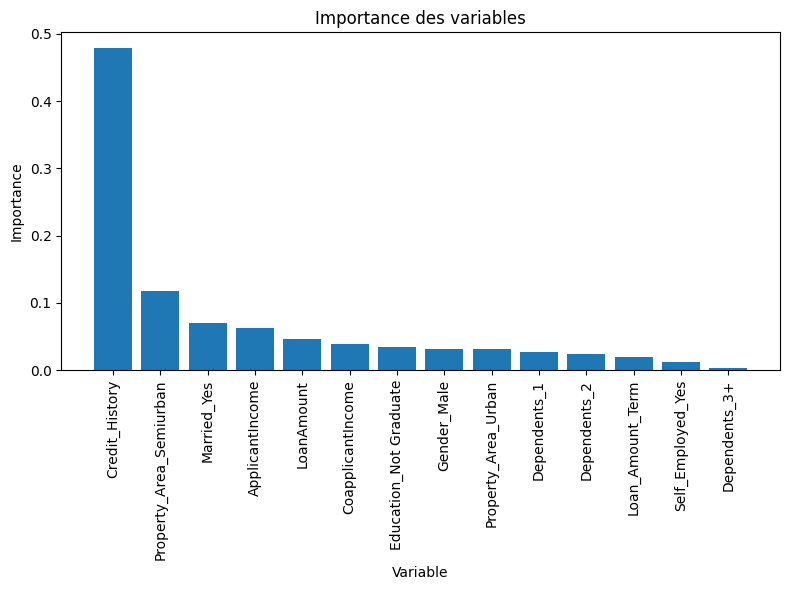

In [287]:
# Obtenir l'importance des variables
importance = random_forest.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': x.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.show()

## PREDICTION

In [288]:
#Tester notre modèle avec les données TEST 
loan_data_test = pd.read_csv("loan_sanction_test.csv")

In [289]:
loan_data_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [290]:
loan_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [291]:
data_test = loan_data_test.copy()

In [292]:
#traitement des valeurs manquantes
"""
Remplacer par le mode pour les variables categorielle et la moyenne pour les variables numérique
"""

mode_gender = data_test['Gender'].mode()[0]
data_test['Gender'].fillna(mode_gender, inplace = True)

#filling the missing values in married column
mode_married = data_test['Married'].mode()[0]
data_test['Married'].fillna(mode_married, inplace = True)

#filling the missing values in dependents column
mode_Dependents = data_test['Dependents'].mode()[0]
data_test['Dependents'].fillna(mode_Dependents, inplace = True)

#Education column has no missing values

#filling the missing values in Self_Employed column
mode_self = data_test['Self_Employed'].mode()[0]
data_test['Self_Employed'].fillna(mode_self, inplace = True)

#filling the missing values in Property_Area column
mode_self = data_test['Property_Area'].mode()[0]
data_test['Property_Area'].fillna(mode_self, inplace = True)

#filling the missing values in Credit_History column
mode_credit = data_test['Credit_History'].mode()[0]
data_test['Credit_History'].fillna(mode_credit, inplace = True)

#filling missing values in numerical columns left
data_test['LoanAmount'].fillna(data_test['LoanAmount'].mean(), inplace = True)
data_test['Loan_Amount_Term'].fillna(data_test['Loan_Amount_Term'].mean(), inplace = True)
print("")
print("")
print("")
print("Missing Values in Filled Data")
print("")
miss_vals = data_test.isnull()
print(miss_vals.sum())




Missing Values in Filled Data

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


In [293]:
#coder les variables catégorielle - utilisation du one-hot-encoding
# One-hot encoding

cat_var = ['Gender','Married','Dependents','Education','Self_Employed', 'Property_Area']
# Créer un objet OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')  # Drop 'first' to avoid multicollinearity

# Appliquer le one-hot encoding sur les colonnes catégorielles
transformed_data_test = ohe.fit_transform(data_test[cat_var])

# Obtenir les noms des colonnes après l'encodage
encoded_column_names = ohe.get_feature_names_out(cat_var)

# Créer un nouveau DataFrame avec les noms de colonnes appropriés
transformed_df_test = pd.DataFrame(transformed_data_test, columns=encoded_column_names)

# Concaténer le DataFrame encodé avec les colonnes restantes du DataFrame d'origine
data_test = pd.concat([transformed_df_test, data_test.drop(columns=cat_var)], axis=1)

print("DataFrame avec one-hot encoding : ")
data_test


DataFrame avec one-hot encoding : 


/home/vmuser/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,LP001015,5720,0,110.0,360.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,LP001022,3076,1500,126.0,360.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LP001031,5000,1800,208.0,360.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LP001035,2340,2546,100.0,360.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,LP001051,3276,0,78.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,LP002971,4009,1777,113.0,360.0,1.0
363,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,LP002975,4158,709,115.0,360.0,1.0
364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,LP002980,3250,1993,126.0,360.0,1.0
365,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LP002986,5000,2393,158.0,360.0,1.0


In [294]:
data_test.drop(['Loan_ID'],axis=1,inplace=True)

In [295]:
data_test=scaling(data_test)

In [296]:
preds_data_test_rf_best=model_rf_best.predict(data_test)